# BEST MODEL
Paste parameters and workflow of best model here

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [13]:
# read in pickled features
df_sj = pd.read_pickle('./datasets/all_sj.pkl')
df_iq = pd.read_pickle('./datasets/all_iq.pkl')

total_cases = pd.read_csv('./datasets/dengue_labels_train.csv')
cases_sj = np.log(total_cases[total_cases['city'] == 'sj']['total_cases'] + 1)
cases_iq = np.log(total_cases[total_cases['city'] == 'iq']['total_cases'] + 1)

# create month variable
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month

# create mean ndvi
df_sj['ndvi_mean'] = (df_sj['ndvi_ne'] + df_sj['ndvi_nw'] + df_sj['ndvi_se'] + df_sj['ndvi_sw']) / 4.0
df_iq['ndvi_mean'] = (df_iq['ndvi_ne'] + df_iq['ndvi_nw'] + df_iq['ndvi_se'] + df_iq['ndvi_sw']) / 4.0

## Train-Validation-Test Split
Because this is time-series data and the features set is dependent on the past, the train test split is very delicate. The validation and test feature set will actually draw from data in the past (rolling mean, std, etc.). Therefore, when creating the model, the entire dataset must be used. But I must be careful not to train the model on data from the 'future'.

In [14]:
# train test split
#sj

# choose split dates
sj_valid_split = '2003-4-20'
sj_test_split = '2008-4-27' # this will split between pre and post submission dates

# split into train, valid, test (no y)
sj_train = df_sj.loc[:sj_valid_split]
sj_Xtrain = sj_train
sj_ytrain = cases_sj[:len(sj_train)]

sj_valid = df_sj.loc[sj_valid_split : sj_test_split]
sj_Xvalid = sj_valid
sj_yvalid = cases_sj[len(sj_train):]

sj_test = df_sj.loc[sj_test_split:]
sj_Xtest = sj_test

print len(sj_train), len(sj_Xtrain), len(sj_ytrain)
print len(sj_valid), len(sj_Xvalid), len(sj_yvalid)
print len(sj_test), len(sj_Xtest)

675 675 675
261 261 261
260 260


In [15]:
#iq

# choose split dates
iq_valid_split = '2007-7-01'
iq_test_split = '2010-7-01' # this will split between pre and post submission dates

# split
iq_train = df_iq.loc[:iq_valid_split]
iq_Xtrain = iq_train
iq_ytrain = cases_iq[:len(iq_Xtrain)]

iq_valid = df_iq.loc[iq_valid_split : iq_test_split]
iq_Xvalid = iq_valid
iq_yvalid = cases_iq[len(iq_train):]

iq_test = df_iq.loc[iq_test_split:]
iq_Xtest = iq_test

# check the lengths
print len(iq_train), len(iq_Xtrain), len(iq_ytrain)
print len(iq_valid), len(iq_Xvalid), len(iq_yvalid)
print len(iq_test), len(iq_Xtest)

364 364 364
156 156 156
156 156


## SJ

In [16]:
print len(pd.get_dummies(sj_Xtrain['month'], prefix='month')), len(sj_ytrain.values)
print len(pd.get_dummies(sj_Xvalid['month'], prefix='month')), len(sj_yvalid.values)

675 675
261 261


615 615
261 261
25.0206700941
0.291109102996


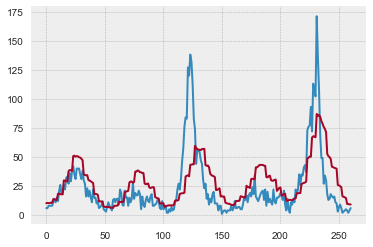

In [94]:
# munge data

# max roll back set to 59

# monthly dummies
Xtrain_months = pd.get_dummies(df_sj['month'], prefix='month')[60:675]

# rolling means df
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[60:675]
Xtrain_means2 = df_sj['ndvi_se'].rolling(window = 20).mean()[60:675]

# combine all dfs
Xtrain = pd.concat([Xtrain_months, Xtrain_means1], axis = 1)
ytrain = cases_sj[60:675]

print len(Xtrain), len(ytrain)

# monthly dummies
Xvalid_months = pd.get_dummies(df_sj['month'], prefix='month')[675:936]

# rolling means df
Xvalid_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[675:936]
Xvalid_means2 = df_sj['ndvi_se'].rolling(window = 20).mean()[675:936]

# combine all dfs
Xvalid = pd.concat([Xvalid_months, Xvalid_means1], axis = 1)
yvalid = cases_sj[675:936]

print len(Xvalid), len(yvalid)

# fit on model, predict
lr_sj = LinearRegression()
lr_sj.fit(Xtrain, ytrain)

sj_valid_cases = pd.Series(np.exp(lr_sj.predict(Xvalid)))

print mean_absolute_error(sj_valid_cases, yvalid)
print lr_sj.score(Xvalid, yvalid)
plt.plot(np.exp(yvalid.values))
plt.plot(sj_valid_cases)

### Notes:

* I will slowly add more features to this graph

## IQ

Do the same as I did for SJ above, but to see which IQ features explain the variance in the residuals.

In [66]:
print len(pd.get_dummies(iq_Xtrain['month'], prefix='month')), len(iq_ytrain.values)
print len(pd.get_dummies(iq_Xvalid['month'], prefix='month')), len(iq_yvalid.values)

364 364
156 156


304 304
156 156
5.00695978194
0.0513201737825


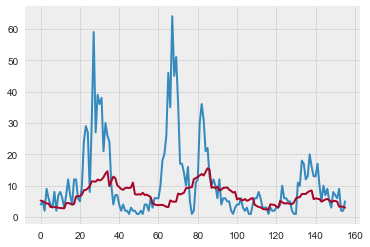

In [98]:
# munge data

# max roll back set to 59

# monthly dummies
Xtrain_months = pd.get_dummies(df_iq['month'], prefix='month')[60:364]

# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 52).mean()[60:364]
Xtrain_means2 = df_iq['ndvi_se'].rolling(window = 20).mean()[60:364]

# combine all dfs
Xtrain = pd.concat([Xtrain_months, Xtrain_means1, Xtrain_means2], axis = 1)
ytrain = cases_iq[60:364]

print len(Xtrain), len(ytrain)

# monthly dummies
Xvalid_months = pd.get_dummies(df_iq['month'], prefix='month')[364:520]

# rolling means df
Xvalid_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[364:520]
Xvalid_means2 = df_iq['ndvi_se'].rolling(window = 20).mean()[364:520]

# combine all dfs
Xvalid = pd.concat([Xvalid_months, Xvalid_means1, Xvalid_means2], axis = 1)
yvalid = cases_iq[364:520]

print len(Xvalid), len(yvalid)

# fit on model, predict
lr_iq = LinearRegression()
lr_iq.fit(Xtrain, ytrain)

iq_valid_cases = pd.Series(np.exp(lr_iq.predict(Xvalid)))

print mean_absolute_error(iq_valid_cases, yvalid)
print lr_iq.score(Xvalid, yvalid)
plt.plot(np.exp(yvalid.values))
plt.plot(iq_valid_cases)

### Notes:

* IQ resiuduals is much more erratic and harder to predict
* Tweak these features more

## USE TEST DATA, MAKE CSV OF SUBMISSIONS

Need to use full dataset (train + test) because values depend on previous weather data

In [99]:
# transform sj data

month_dums = pd.get_dummies(df_sj['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_sj[['station_avg_temp_c']].rolling(window = 55).mean())
ndvi_roll_means = pd.DataFrame(df_sj[['ndvi_se']].rolling(window = 30).mean())
temp_roll_std = pd.DataFrame(df_sj[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test set
Xtest = pd.concat([month_dums, temp_roll_means, ndvi_roll_means, temp_roll_std], axis = 1)

# train model
lr_sj_full = LinearRegression()
lr_sj_full.fit(Xtest[60:-260], cases_sj.values[60:])

# predicts
sj_full_preds = np.exp(lr_sj_full.predict(Xtest[55:]))
sj_submit_preds = sj_full_preds[-260:]

21.0797523469


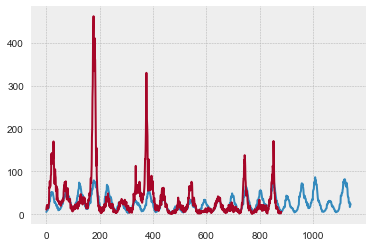

In [100]:
plt.plot(sj_full_preds)
plt.plot(np.exp(cases_sj.values[55:]))
print mean_absolute_error(sj_full_preds[:-260], np.exp(cases_sj.values[55:]))

In [101]:
# transform iq data
month_dums = pd.get_dummies(df_iq['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_iq[['ndvi_nw']].rolling(window = 68).mean())
temp_roll_std = pd.DataFrame(df_iq[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test
Xtest = pd.concat([month_dums, temp_roll_means, temp_roll_std], axis = 1)

# train
lr_iq_full = LinearRegression()
lr_iq_full.fit(Xtest[68:-156], cases_iq.values[68:])

# predicts
iq_full_preds = np.exp(lr_iq_full.predict(Xtest[68:]))
iq_submit_preds = iq_full_preds[-156:]

5.48023959753


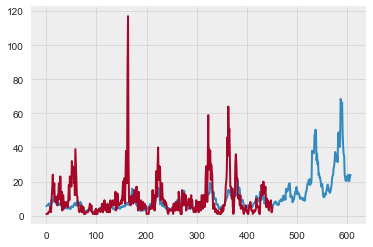

In [102]:
plt.plot(iq_full_preds)
plt.plot(np.exp(cases_iq.values[68:]))
print mean_absolute_error(iq_full_preds[:-156], np.exp(cases_iq.values[68:]))

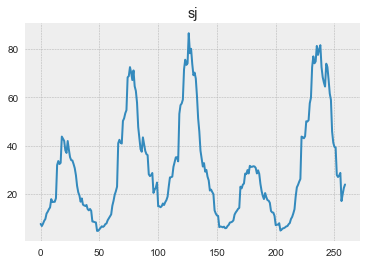

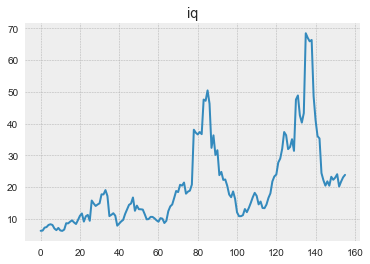

In [103]:
plt.plot(sj_submit_preds)
plt.title('sj')
plt.show()
plt.plot(iq_submit_preds)
plt.title('iq')
plt.show()

In [104]:
total_preds = list(sj_submit_preds) + list(iq_submit_preds)

### make csv

In [105]:
# submission
submission_format = pd.read_csv('./datasets/submission_format.csv')

In [106]:
submission_format['total_cases'] = total_preds
submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))

In [108]:
# Save to CSV, use current date
submission_format.to_csv('submissions/dengue_submission_9_19_17v3.csv', index=False)

In [ ]:
## MAE on DrivenData of 26... sad  :( 